In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

In [1]:
import tensorflow as tf

ImportError: Traceback (most recent call last):
  File "/home/ehsan/anaconda3/lib/python3.7/site-packages/tensorflow/python/__init__.py", line 49, in <module>
    from tensorflow.python import pywrap_tensorflow
  File "/home/ehsan/anaconda3/lib/python3.7/site-packages/tensorflow/python/pywrap_tensorflow.py", line 28, in <module>
    _pywrap_tensorflow = swig_import_helper()
  File "/home/ehsan/anaconda3/lib/python3.7/site-packages/tensorflow/python/pywrap_tensorflow.py", line 24, in swig_import_helper
    _mod = imp.load_module('_pywrap_tensorflow', fp, pathname, description)
  File "/home/ehsan/anaconda3/lib/python3.7/imp.py", line 242, in load_module
    return load_dynamic(name, filename, file)
  File "/home/ehsan/anaconda3/lib/python3.7/imp.py", line 342, in load_dynamic
    return _load(spec)
ImportError: /home/ehsan/anaconda3/lib/python3.7/site-packages/tensorflow/python/_pywrap_tensorflow.so: invalid ELF header


Error importing tensorflow.  Unless you are using bazel,
you should not try to import tensorflow from its source directory;
please exit the tensorflow source tree, and relaunch your python interpreter
from there.

In [3]:
milk = pd.read_csv('EURUSD15.csv')

In [5]:
columnName = ['a','b','c','d','e','f','g']

In [6]:
milk.columns = columnName

In [7]:
milk.head()


,a,b,c,d,e,f,g
0,2018.06.06,05:15,1.17234,1.17244,1.17215,1.17220,596
1,2018.06.06,05:30,1.17220,1.17221,1.17181,1.17210,893
2,2018.06.06,05:45,1.17210,1.17229,1.17202,1.17226,587
3,2018.06.06,06:00,1.17226,1.17226,1.17190,1.17202,752
4,2018.06.06,06:15,1.17202,1.17222,1.17201,1.17217,552


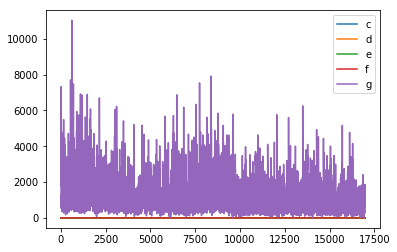

In [8]:
milk.plot()

In [22]:
train_set = milk.head(17000)
train_set = train_set[['c','d']]

In [27]:
test_set = milk.tail(500)
test_set = test_set[['c','d']]

In [28]:
from sklearn.preprocessing import MinMaxScaler

In [29]:
scaler = MinMaxScaler()

In [30]:
train_scaled = scaler.fit_transform(train_set)

In [31]:
test_scaled = scaler.transform(test_set)

In [32]:
def next_batch(training_data,batch_size,steps):
    
    
    # Grab a random starting point for each batch
    rand_start = np.random.randint(0,len(training_data)-steps) 

    # Create Y data for time series in the batches
    y_batch = np.array(training_data[rand_start:rand_start+steps+1]).reshape(1,steps+1)

    return y_batch[:, :-1].reshape(-1, steps, 1), y_batch[:, 1:].reshape(-1, steps, 1) 

In [34]:
import tensorflow as tf

ImportError: Traceback (most recent call last):
  File "/home/ehsan/anaconda3/lib/python3.7/site-packages/tensorflow/python/__init__.py", line 49, in <module>
    from tensorflow.python import pywrap_tensorflow
  File "/home/ehsan/anaconda3/lib/python3.7/site-packages/tensorflow/python/pywrap_tensorflow.py", line 28, in <module>
    _pywrap_tensorflow = swig_import_helper()
  File "/home/ehsan/anaconda3/lib/python3.7/site-packages/tensorflow/python/pywrap_tensorflow.py", line 24, in swig_import_helper
    _mod = imp.load_module('_pywrap_tensorflow', fp, pathname, description)
  File "/home/ehsan/anaconda3/lib/python3.7/imp.py", line 242, in load_module
    return load_dynamic(name, filename, file)
  File "/home/ehsan/anaconda3/lib/python3.7/imp.py", line 342, in load_dynamic
    return _load(spec)
ImportError: /home/ehsan/anaconda3/lib/python3.7/site-packages/tensorflow/python/_pywrap_tensorflow.so: invalid ELF header


Error importing tensorflow.  Unless you are using bazel,
you should not try to import tensorflow from its source directory;
please exit the tensorflow source tree, and relaunch your python interpreter
from there.